# Quality check of OPM sensors
The aim of this section is to conduct a basic quality check of set of OPM sensors. This will be done by calculating the power spectra for each sensor as well as showing a few examples.

### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import array
from datetime import datetime
from matplotlib.ticker import ScalarFormatter

### Data Loading
Fieldline OPM-MEG stores the data in the FIF format. The first step is to retrieve the raw data by defining the file name and directory path. After reading the raw data they will be stored in an object name $raw $ 

In [2]:
directory_path = '/home/rakshita/rds_folders/Sproject3/EmptyRoom/Recordings'
file_name='Empty_main.fif'
#file_name='Ox_emp_data1.fif'
data_path=os.path.join(directory_path,file_name)
raw = mne.io.read_raw_fif(data_path, preload=True)

Opening raw data file /home/rakshita/rds_folders/Sproject3/EmptyRoom/Recordings/Empty_main.fif...


/tmp/ipykernel_14057/1552979776.py:5: RuntimeWarning: This filename (/home/rakshita/rds_folders/Sproject3/EmptyRoom/Recordings/Empty_main.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


    Range : 0 ... 1499999 =      0.000 ...   300.000 secs
Ready.
Reading 0 ... 1499999  =      0.000 ...   300.000 secs...


In [3]:
raw.info

<Info | 17 non-empty values
 bads: []
 ch_names: L102_bz-s73, L104_bz-s80, L106_bz-s84, L108_bz-s77, L110_bz-s76, ...
 chs: 69 Magnetometers, 1 Stimulus
 custom_ref_applied: False
 description: {"chassis":{"version":"0.9.4- ...
 dig: 6 items (3 Cardinal, 3 HPI)
 experimenter: AK
 file_id: 4 items (dict)
 gantry_angle: 0.0
 highpass: 0.0 Hz
 line_freq: 0.0
 lowpass: 500.0 Hz
 meas_date: 2024-11-08 15:02:12 UTC
 meas_id: 4 items (dict)
 nchan: 70
 proj_id: 1 item (ndarray)
 proj_name: SpattOPM
 projs: []
 sfreq: 5000.0 Hz
 xplotter_layout: None
>

### Estimating the PSDs
As a first step calcualte the PSDs of all the sensors for A 1-120 HZ frequency range using the MNE functions. The PSD values are converted to decibel (dB) with respect to the reference of $1fT^2/Hz$ power. As such the result units are $dB [fT^2/Hz]$. Also note that the sampling frequency 5000 Hz and therefore chose $N_{FFT}$ = 10000 to achive a 0.5 Hz spectral resolution. 

In [4]:
n_fft = 10000
raw_PSD = raw.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))
psds = raw_PSD.get_data() # units are in T^2/Hz
freqs = raw_PSD.freqs 

Effective window size : 2.000 (s)


Plotting power spectral density (dB=True).


/home/rakshita/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


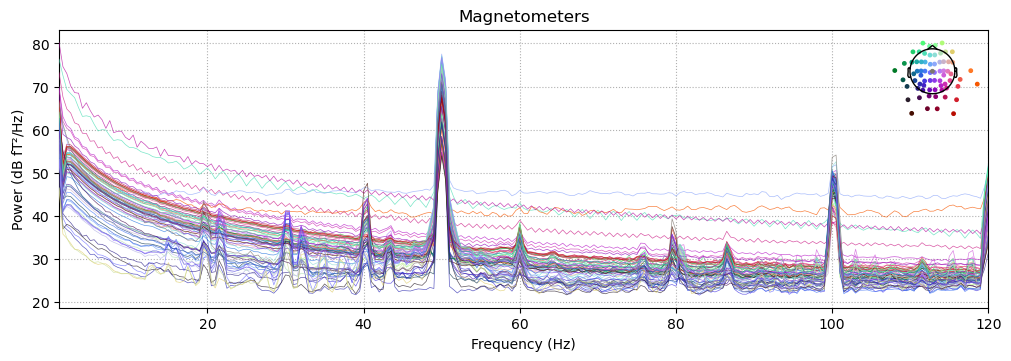

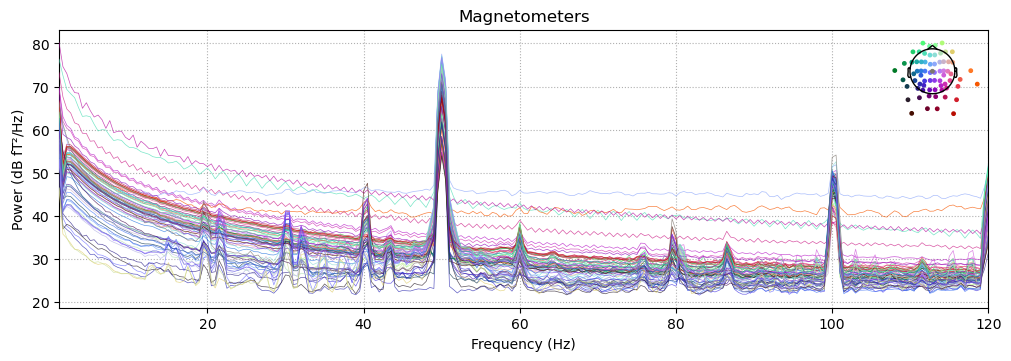

In [5]:
raw_PSD.plot()

### Ranking the PSDs according to average power

To rank the sensors based on the average power, compute the average power of each sensor and sort them accordingly.

In [6]:
# Convert to db
avg_psd = [10 * np.log10(psd * 1e30) for psd in psds] # Ref power: 1fT^2=1e-30T^2
average_power = np.mean(avg_psd, axis=1)
## Get Only MEG channels
mag_channels = mne.pick_types(raw.info, meg=True, stim=False)
channel_names = [raw.info['ch_names'][i] for i in mag_channels]

ch_power_data = list(zip(channel_names, average_power, avg_psd))
ch_power_data_s = sorted(ch_power_data, key=lambda x: x[1], reverse=True) # Sorting by average power

s_channel_names = [channel for channel, power, psd in ch_power_data_s] #Sorted Channel names
s_average_power = [power for channel, power, psd in ch_power_data_s]
s_psds = [psd for channel, power, psd in ch_power_data_s]

### Plot the PSD of each sensor according to their rank 
As a next step the sensors for each PSD will be plotted. Note the scale of the power is the same for all sensors.

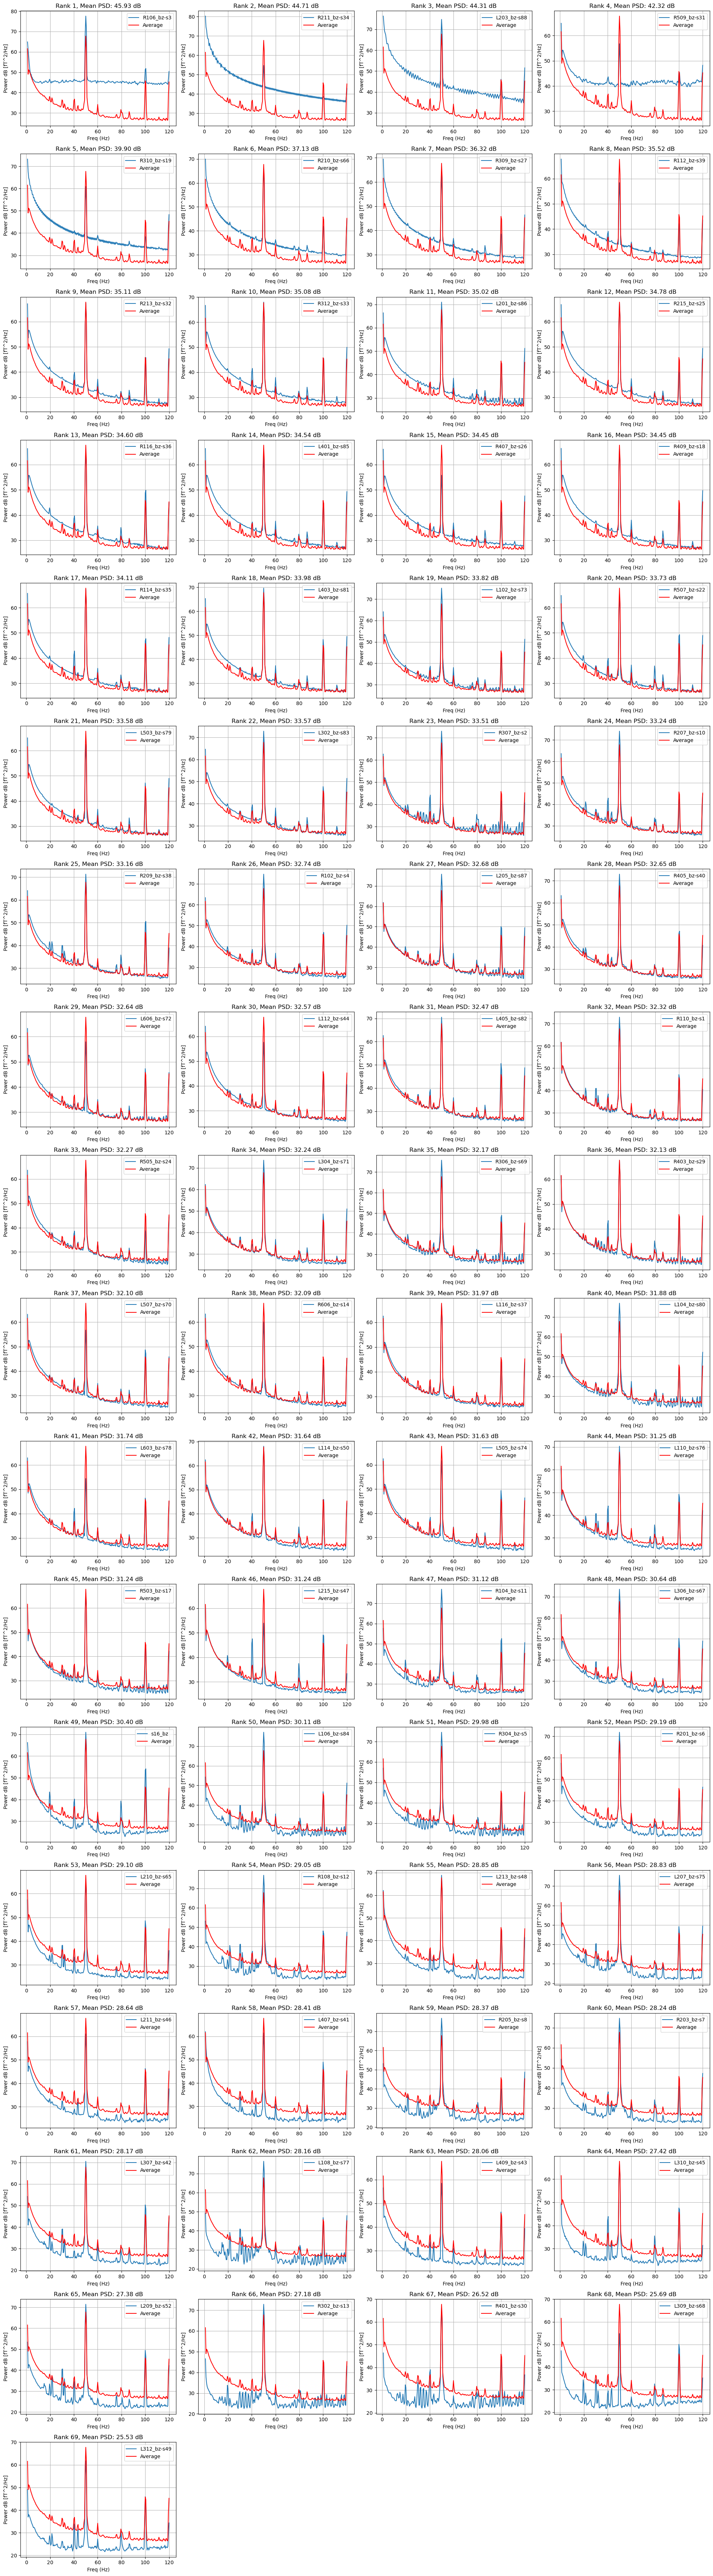

In [7]:
n_channels = len(s_channel_names)
n_cols = 4  
n_rows = 18

ymin = 20 
ymax = 70 
grand_avg_psd = np.mean(s_psds, axis=0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for rank, (channel, avg_power, psd) in enumerate(ch_power_data_s):
    ax = axes[rank]
    ax.plot(freqs, psd, label=f'{channel}')
    ax.plot(freqs, grand_avg_psd, label='Average', color='red')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power dB [fT^2/Hz]')
    avg_psd_value = np.mean(psd)
    ax.set_title(f'Rank {rank + 1}, Mean PSD: {avg_psd_value:.2f} dB')
    #ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True)

# Delete remaining unused subplots
for ax in axes[len(s_channel_names):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

### A bar chart over the sensor power 
To get on overview of the power across sensors make a bar chart.

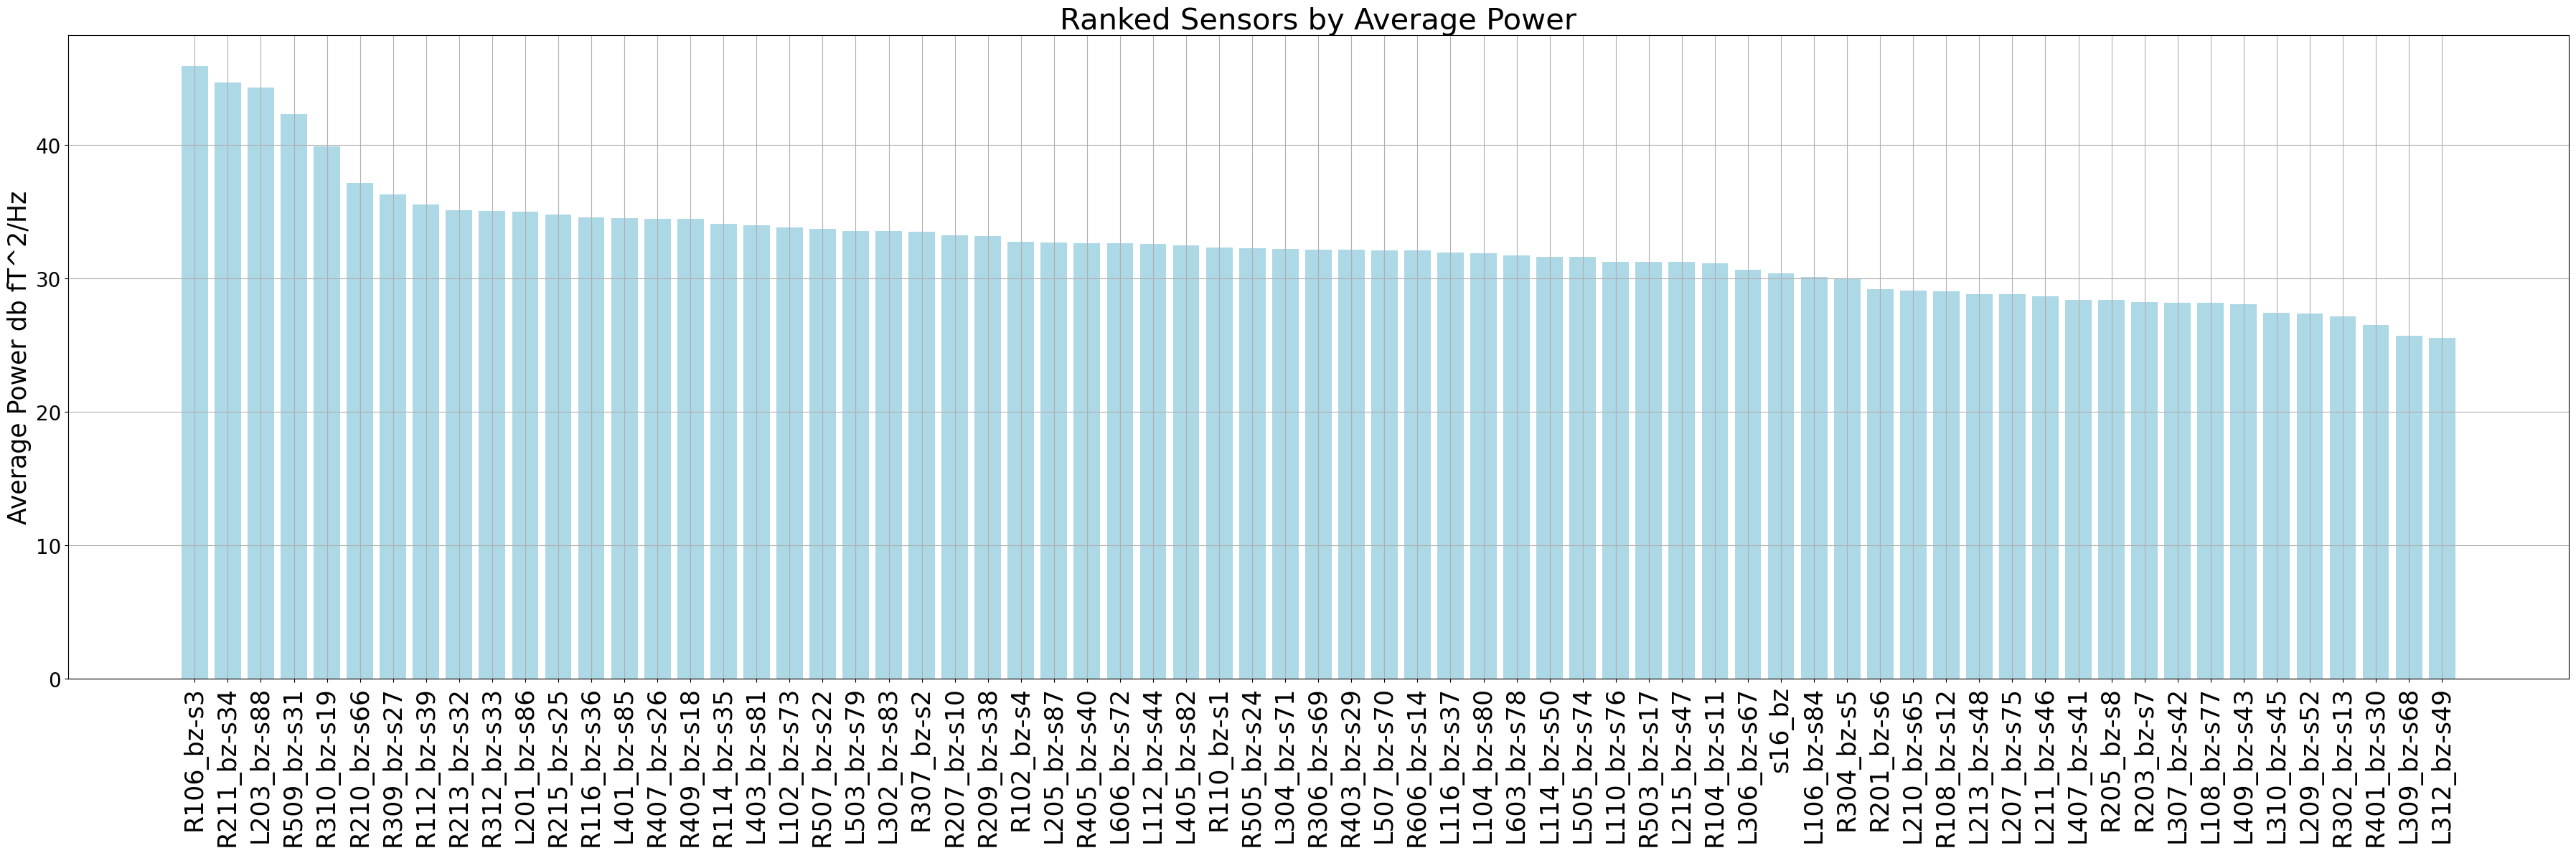

In [8]:
plt.figure(figsize=(36, 12))
plt.bar(s_channel_names, s_average_power, color='lightblue')
#plt.xlabel('Average Power db(fT^2/Hz)')
plt.ylabel('Average Power db fT^2/Hz',fontsize=25)
plt.title('Ranked Sensors by Average Power',fontsize=30)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
#plt.savefig("bar_plot_old2.jpg", format='jpg', dpi=300)  # Specify the filename, format, and resolution

plt.show()

### Plotting the time course of representative sensors  
To get an overview of the time-course of the sensor activity, plot the time course of the 3 most noisy and 3 least noisy raw sensor over the full time-window

In [9]:
### Identifying the most and least noisy channels
plot_channels = s_channel_names[:3] + s_channel_names[-3:]
most_noisy_channels = s_channel_names[:3]
least_noisy_channels = s_channel_names[-3:]

print("3 most noisy channel names:", most_noisy_channels)
print("3 least noisy channel names:", least_noisy_channels)

3 most noisy channel names: ['R106_bz-s3', 'R211_bz-s34', 'L203_bz-s88']
3 least noisy channel names: ['R401_bz-s30', 'L309_bz-s68', 'L312_bz-s49']


In [ ]:
raw_plot_chans = raw.copy().pick_channels(plot_channels)
plt.figure(figsize=(12, 8))

for i, sensor_name in enumerate(most_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    data_zero_mean = data[0] - np.mean(data[0])  # Zero-mean 
    plt.plot(times, data_zero_mean*1e15, label=sensor_name, color='red',linewidth=0.1)

for i, sensor_name in enumerate(least_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    data_zero_mean = data[0] - np.mean(data[0])  # Zero-mean operation
    plt.plot(times, data_zero_mean*1e15, label=sensor_name, color='blue',linewidth=0.1)
#plt.ylim([-1.25*(1e6), 0.75*(1e6)])
#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#plt.gca().ticklabel_format(axis="y", style="scientific", scilimits=(5, 5))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.title('3 Most Noisy + 3 Least Noisy Sensor Data Over Time')
#plt.legend()
plt.show()

As clear from above there was a large event at 110 s. This happens to be an elavator in the building moving.

To have closer view of the noise levels, plot a 200 ms stretch of the data (from 25 to 25.2 s):

In [ ]:
plt.figure(figsize=(12, 8))

# Define the interval for which you want to see the plot
t1 = 25
t2 = 25.2
Fs = 5000  # Sampling Frequency

# Set DC offset for better viewing
noisy_offset = 10000  # increment for most_noisy sensors
non_noisy_offset = 20000  # increment for least_noisy sensors.

# Plot most noisy sensors
for i, sensor_name in enumerate(most_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    start_idx = int(np.round(t1 * Fs))
    end_idx = int(np.round(t2 * Fs))
    cropped_data = data[0][start_idx:end_idx]
    data_zero_mean = (cropped_data - np.mean(cropped_data)) * 1e15  
    data_zero_mean += noisy_offset + (i * non_noisy_offset)  # Offset by group
    plt.plot(times[start_idx:end_idx], data_zero_mean, color='red', label='Most Noisy Sensors' if i == 0 else "")

# Adjust offset 
least_noisy_base_offset = noisy_offset + (len(most_noisy_channels) * non_noisy_offset) + 20000  

# Plot least noisy sensors
for i, sensor_name in enumerate(least_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    start_idx = int(np.round(t1 * Fs))
    end_idx = int(np.round(t2 * Fs))
    cropped_data = data[0][start_idx:end_idx]
    data_zero_mean = (cropped_data - np.mean(cropped_data)) * 1e15  # Scale to fT
    data_zero_mean += least_noisy_base_offset + (i * non_noisy_offset)
    plt.plot(times[start_idx:end_idx], data_zero_mean, color='blue', label='Least Noisy Sensors' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.title(f'Most Noisy and Least Noisy Sensor Data Over {t1}s to {t2}s with Vertical Offsets')
plt.legend()
plt.show()


It is also possible to use the interactive tool in MNE Python for browsing the time course

In [ ]:
## Sensor data plot
raw.plot(picks=plot_channels, title='3 most and 3 least noisy Sensor data', show=True)

In [ ]:
## Zero-mean plot with the default MNE raw.plot function

In [ ]:
raw_zero_mean = raw.copy().pick(plot_channels)
raw_zero_mean._data -= np.mean(raw_zero_mean._data, axis=1, keepdims=True)
raw_zero_mean.plot(title='3 most and 3 least noisy Sensor data', show=True)